## Import Libraries

In [ ]:
import torch
import torchvision
import cv2
from PIL import Image
from torchvision.transforms import transforms as transforms
import numpy as np
import random
import argparse
import glob
import matplotlib.pyplot as plt

In [ ]:
!pip install ignite
import ignite

In [ ]:
import ignite.metrics.confusion_matrix.ConfusionMatrix

In [ ]:
cm = ConfusionMatrix(num_classes=3)
metric = IoU(cm)
metric.attach(default_evaluator, 'iou')
y_true = torch.Tensor([0, 1, 0, 1, 2]).long()
y_pred = torch.Tensor([
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
])
state = default_evaluator.run([[y_pred, y_true]])
print(state.metrics['iou'])

tensor([0, 1, 0, 1, 2])

In [ ]:
# this will help us create a different color for each class
COLORS = np.random.uniform(0, 255, size=(91, 3))

## Some Utility Function for Semantic Segmentation

### Get Model Ouput

In [ ]:
def get_outputs(image, model, threshold):
    with torch.no_grad():
        # forward pass of the image through the modle
        outputs = model(image)
    
    # get all the scores
    scores = list(outputs[0]['scores'].detach().cpu().numpy())
    # index of those scores which are above a certain threshold
    thresholded_preds_inidices = [scores.index(i) for i in scores if i > threshold]
    thresholded_preds_count = len(thresholded_preds_inidices)
    # get the masks
    masks = (outputs[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    # discard masks for objects which are below threshold
    masks = masks[:thresholded_preds_count]

    return masks

### Applying Segmentation Masks

In [ ]:
def draw_segmentation_map(image, masks):
    alpha = 1 
    beta = 0.6 # transparency for the segmentation map
    gamma = 0 # scalar added to each sum
    for i in range(len(masks)):
        red_map = np.zeros_like(masks[i]).astype(np.uint8)
        green_map = np.zeros_like(masks[i]).astype(np.uint8)
        blue_map = np.zeros_like(masks[i]).astype(np.uint8)

        # apply a randon color mask to each object
        color = COLORS[random.randrange(0, len(COLORS))]
        red_map[masks[i] == 1], green_map[masks[i] == 1], blue_map[masks[i] == 1]  = color
        # combine all the masks into a single image
        segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
        #convert the original PIL image into NumPy format
        image = np.array(image)
        # convert from RGN to OpenCV BGR format
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        # apply mask on the image
        cv2.addWeighted(image, alpha, segmentation_map, beta, gamma, image)
    return image

## Applying Mask R-CNN on Images

### Prepare the Model and Define the Transform

In [ ]:
# initialize the model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, progress=True, 
                                                           num_classes=91)
# set the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# load the modle on to the computation device and set to eval mode
model.to(device).eval()

In [ ]:
# transform to convert the image to tensor
transform = transforms.Compose([
    transforms.ToTensor()
])

### Read the Images and Applying Semantic Segmentation

In [ ]:
images = []
orig_images = []
for f in glob.iglob("./input/*"):
    image = Image.open(f).convert('RGB')
    orig_image = image.copy()
    image = transform(image)
    image = image.unsqueeze(0).to(device)
    images.append(image)
    orig_images.append(orig_image)


<Figure size 432x288 with 0 Axes>

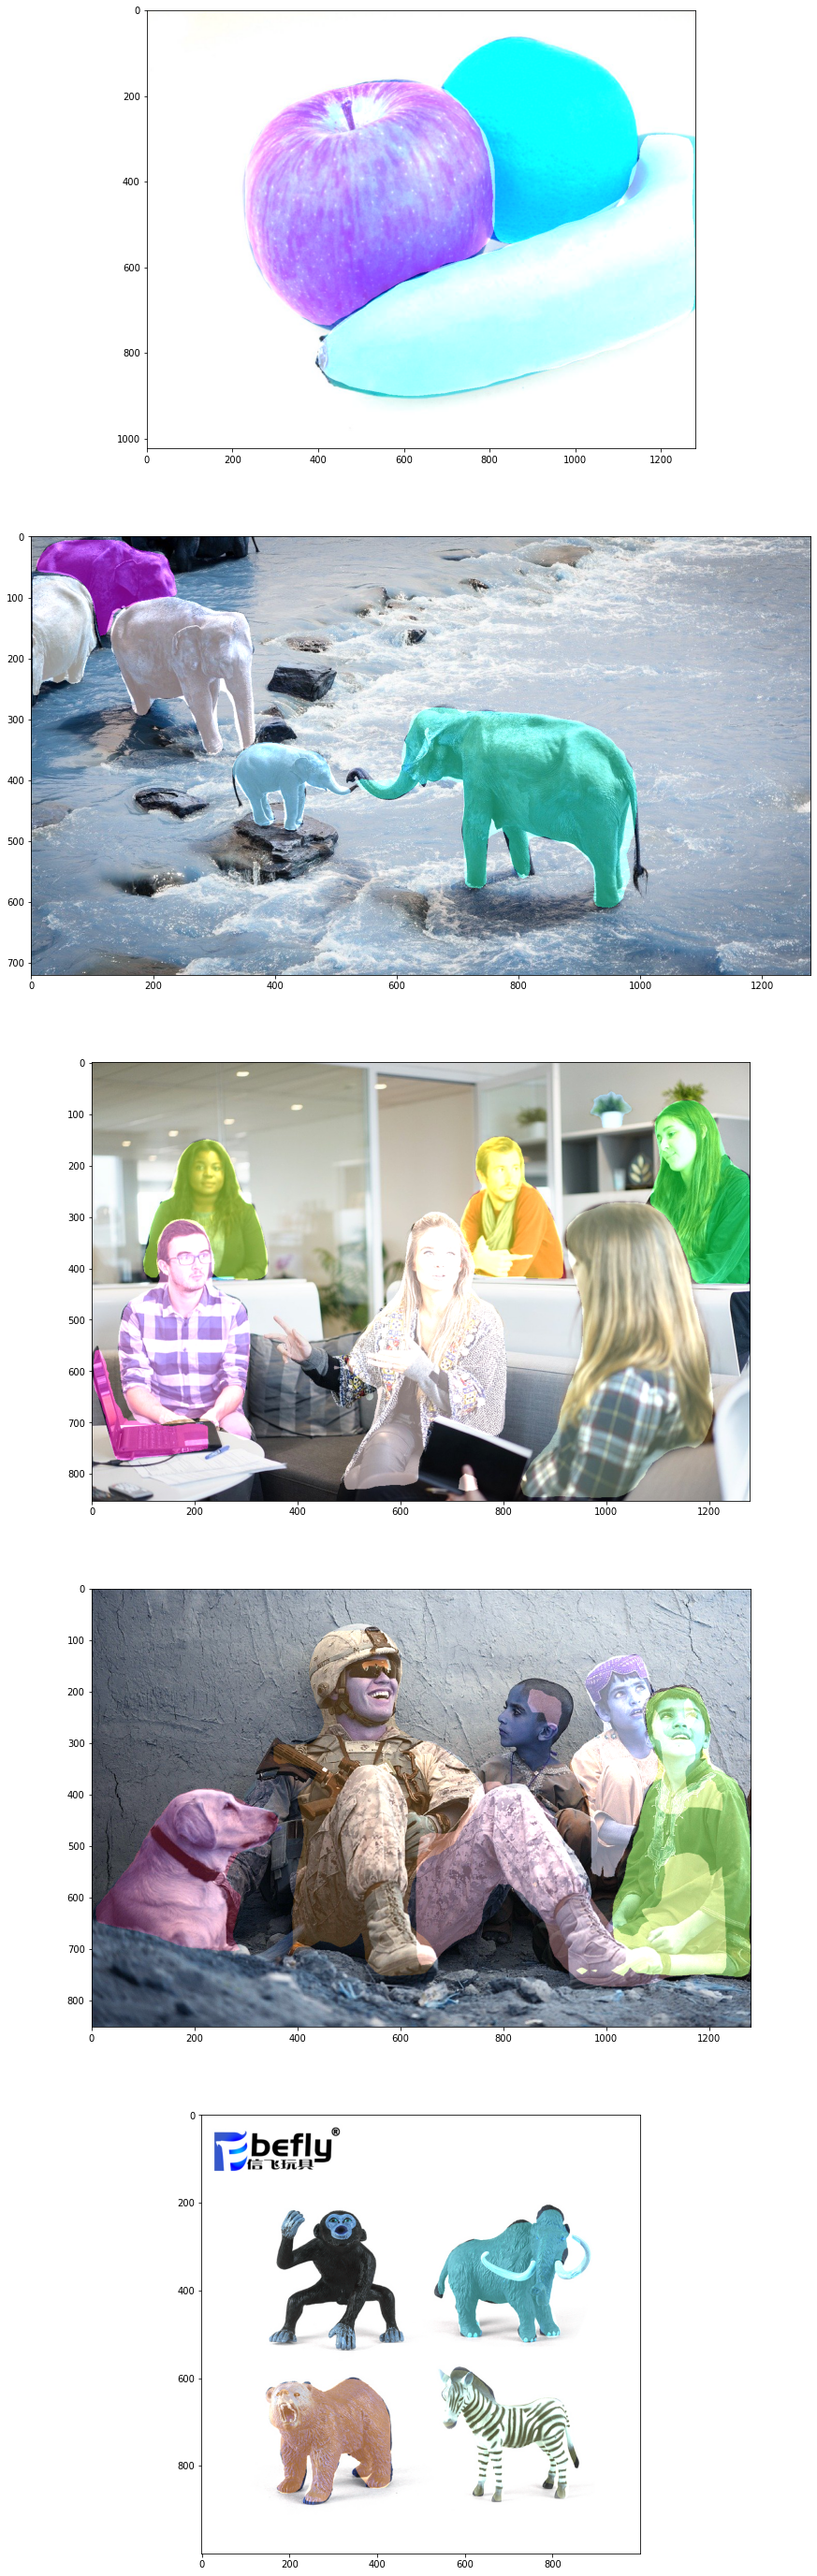

In [ ]:
plt.figure()
f, axarr = plt.subplots(nrows=len(images), ncols=1, figsize=(20, 10*len(images)))
for i in range(len(images)):
  image = images[i]
  orig_image = orig_images[i]
  masks= get_outputs(image, model, 0.965)
  result = draw_segmentation_map(orig_image, masks)
  axarr[i].imshow(result)

In [ ]:
print(masks[2][600][200])

True
